In [1]:
import datasets
from xsum_dataset import XsumDataset

In [2]:
xsum_data_raw = datasets.load_dataset("xsum")

Using custom data configuration default
Reusing dataset xsum (/home/wk247/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# train/val/test data
# xsum_train_data = XsumDataset(xsum_data_raw["train"])
xsum_val_data = XsumDataset(xsum_data_raw["validation"])
xsum_test_data = XsumDataset(xsum_data_raw["test"])

In [4]:
from generate_xsum_summary import load_summarization_model_and_tokenizer, generate_summaries, generate_token_entropy_metadata
import random

random.seed(0)

In [17]:
from ner_utils import *

In [18]:
log_probs_cache_dir = "/home/wk247/workspace/xsum_analysis/cache/log_probs"

In [55]:
original_ood_prob_list = load_from_cache_dir("original_log_probs_list", log_probs_cache_dir)
ood_log_probs_list_insert_1_random = load_from_cache_dir("ood_log_probs_list_insert_1_random", log_probs_cache_dir)
ood_log_probs_list_insert_1_top1 = load_from_cache_dir("ood_log_probs_list_insert_1_top1", log_probs_cache_dir)
ood_log_probs_list_insert_2_random = load_from_cache_dir("ood_log_probs_list_insert_2_random", log_probs_cache_dir)
ood_log_probs_list_insert_2_topbottom = load_from_cache_dir("ood_log_probs_list_insert_2_topbottom", log_probs_cache_dir)
ood_log_probs_list_ner = load_from_cache_dir("ood_log_probs_list_ner", log_probs_cache_dir)

'/home/wk247/workspace/xsum_analysis/cache/log_probs/original_log_probs_list.pkl' loaded
'/home/wk247/workspace/xsum_analysis/cache/log_probs/ood_log_probs_list_insert_1_random.pkl' loaded
'/home/wk247/workspace/xsum_analysis/cache/log_probs/ood_log_probs_list_insert_1_top1.pkl' loaded
'/home/wk247/workspace/xsum_analysis/cache/log_probs/ood_log_probs_list_insert_2_random.pkl' loaded
'/home/wk247/workspace/xsum_analysis/cache/log_probs/ood_log_probs_list_insert_2_topbottom.pkl' loaded
'/home/wk247/workspace/xsum_analysis/cache/log_probs/ood_log_probs_list_ner.pkl' loaded


In [29]:
len(original_ood_prob_list) == len(ood_log_probs_list_insert_1_random) \
== len(ood_log_probs_list_insert_1_top1) == len(ood_log_probs_list_insert_2_random) \
== len(ood_log_probs_list_insert_2_topbottom) == len(ood_log_probs_list_ner)

True

In [49]:
import torch
import numpy as np

In [64]:
def calculate_KL(p_s, q_s):
    assert len(p_s) == len(q_s)
    kl_list = []
    for p, q in zip(p_s, q_s):
        if q == None:
            kl_list.append(np.nan)
            continue
        
        assert p.size(0) == q.size(0)
        num_y = p.size(0)
        
        p = p.cpu()
        q = q.cpu()
        kl_list.append((torch.sum(p - q) / num_y).item())
    return np.array(kl_list)

In [33]:
original_ood_prob_list[0].size()

torch.Size([30])

In [32]:
ood_log_probs_list_insert_1_random[0].cpu()

tensor([-11.9782, -13.3513, -12.5838, -13.0289, -13.2889, -12.6384, -13.0642,
        -14.2455, -13.8305, -13.6964, -13.3160, -13.3069, -12.3476, -12.5619,
        -13.7266, -15.1430, -13.9522, -15.1037, -13.7510, -14.4966, -13.8416,
        -15.1953, -13.3027, -12.6547, -14.0787, -13.9904, -14.7668, -15.5496,
        -14.8441, -14.3661])

In [58]:
for idx, t in enumerate(ood_log_probs_list_ner):
    if type(t) == list:
        ood_log_probs_list_ner[idx] = None

In [65]:
insert_1_random_KL = calculate_KL(original_ood_prob_list, ood_log_probs_list_insert_1_random)
insert_1_top1_KL = calculate_KL(original_ood_prob_list, ood_log_probs_list_insert_1_top1)
insert_2_random_KL = calculate_KL(original_ood_prob_list, ood_log_probs_list_insert_2_random)
insert_2_topbottom_KL = calculate_KL(original_ood_prob_list, ood_log_probs_list_insert_2_topbottom)

ner_KL = calculate_KL(original_ood_prob_list, ood_log_probs_list_ner)

In [90]:
def get_stats(array):
    return np.nanmean(array), np.nanmedian(array), np.nanstd(array)

In [95]:
insert_1_random_KL_mean, insert_1_random_KL_median, insert_1_random_KL_std = get_stats(insert_1_random_KL)
insert_1_top_KL_mean, insert_1_top_KL_median, insert_1_top_KL_std = get_stats(insert_1_top1_KL)
insert_2_random_KL_mean, insert_2_random_KL_median, insert_2_random_KL_std = get_stats(insert_2_random_KL)
insert_2_topbottom_KL_mean, insert_2_topbottom_KL_median, insert_2_topbottom_KL_std = get_stats(insert_2_topbottom_KL)
ner_KL_mean, ner_KL_median, ner_KL_std = get_stats(ner_KL)

In [93]:
print(f"insert 1 sentencence to the random position of the document- mean:{insert_1_random_KL_mean:.3f}, \
      median:{insert_1_random_KL_median:.3f}, \
      std:{insert_1_random_KL_std:.3f}")

insert 1 sentencence to the random position of the document- mean:2.107,       median:0.818,       std:3.102


In [83]:
print(f"insert 1 sentencence to the top of the document- mean:{insert_1_top1_KL.mean():.3f}, \
      median:{np.median(insert_1_top1_KL):.3f}, \
      std:{insert_1_top1_KL.std():.3f}")

insert one sentencence to the top of the document- mean:5.007,       median:4.146,       std:3.962


In [84]:
print(f"insert two sentencences to the random position of the document- mean:{insert_2_random_KL.mean():.3f}, \
      median:{np.median(insert_2_random_KL):.3f}, \
      std:{insert_2_random_KL.std():.3f}")

insert two sentencences to the random position of the document- mean:3.634,       median:2.172,       std:4.164


In [85]:
print(f"insert two sentencences to the top and bottom of the document- mean:{insert_2_topbottom_KL.mean():.3f}, \
      median:{np.median(insert_2_topbottom_KL):.3f}, \
      std:{insert_2_topbottom_KL.std():.3f}")

insert two sentencences to the top and bottom of the document- mean:5.704,       median:4.726,       std:4.387


In [88]:
print(f"replace named entity of the document- mean:{np.nanmean(ner_KL):.3f}, \
      median:{np.nanmedian(ner_KL):.3f}, \
      std:{np.nanstd(ner_KL):.3f}")

replace named entity of the document- mean:7.003,       median:5.021,       std:6.939


# visualize

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
# Create lists for the plot
x_s = ['Insert1_random','Insert1_top', 'Insert2_random', 'Insert2_top_bottom', 'Named_entity']
x_pos = np.arange(len(x_s))
means = [insert_1_random_KL_mean, insert_1_top_KL_mean, insert_2_random_KL_mean, insert_2_topbottom_KL_mean, ner_KL_mean]
medians = [insert_1_random_KL_median, insert_1_top_KL_median, insert_2_random_KL_median, insert_2_topbottom_KL_median, ner_KL_median]
stds = [insert_1_random_KL_std, insert_1_top_KL_std, insert_1_random_KL_std, insert_2_topbottom_KL_mean, ner_KL_std]

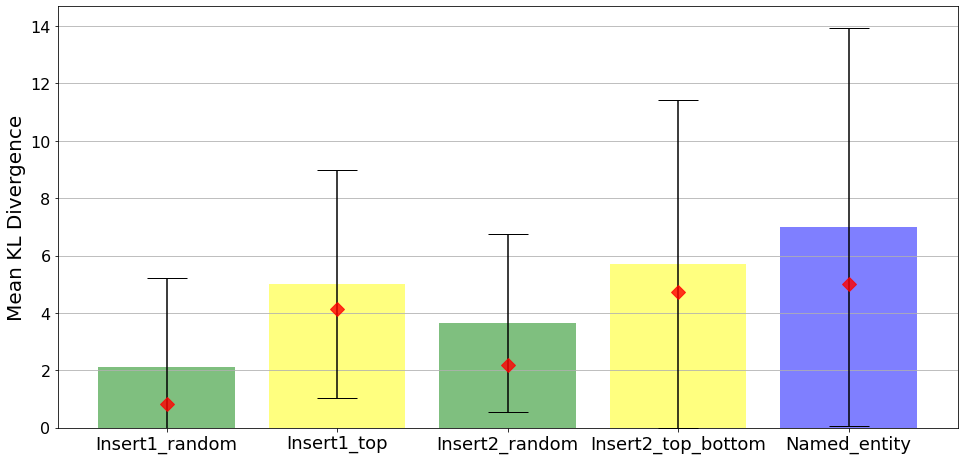

In [166]:
# Build the plot
fig, ax = plt.subplots()
fig.set_size_inches(13.5, 6.5)
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=20,
      color=['green', 'yellow', 'green', 'yellow', 'blue'])
ax.set_ylabel('Mean KL Divergence', fontsize=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_s, fontsize=18)
ax.yaxis.grid(True)
plt.ylim(bottom=0)

# add median
plt.plot(x_pos, medians, marker="D", linestyle="", alpha=0.8, color="red", markersize=10)

# Save the figure and show
plt.tight_layout()
plt.savefig('./vis/kl_mean_std.png')
plt.show()

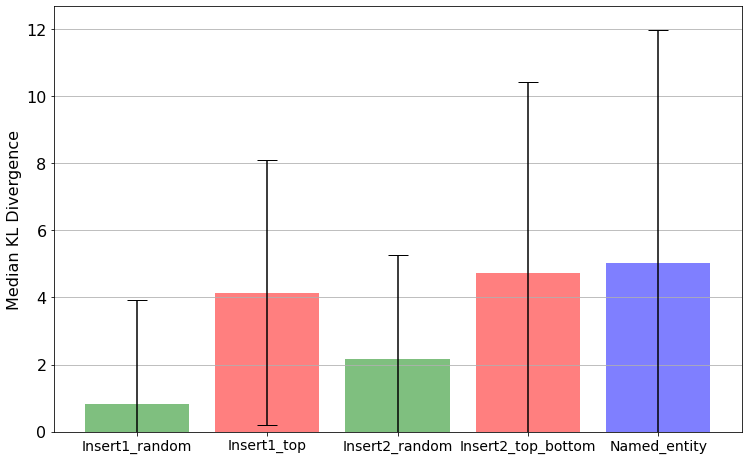

In [147]:
# Build the plot
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 6.5)
ax.bar(x_pos, medians, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10,
      color=['green', 'red', 'green', 'red', 'blue'])
ax.set_ylabel('Median KL Divergence', fontsize=16)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_s, fontsize=14)
ax.yaxis.grid(True)
plt.ylim(bottom=0)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

# groupby ner

In [167]:
ood_ner_cache_dir = "/home/wk247/workspace/xsum_analysis/cache/ood_ner"

In [168]:
ood_ner_list = load_from_cache_dir("ood_list", ood_ner_cache_dir)

'/home/wk247/workspace/xsum_analysis/cache/ood_ner/ood_list.pkl' loaded


In [204]:
ent_pool_dict = load_from_cache_dir("val_test_ent_pool_dict", "/home/wk247/workspace/xsum_analysis/cache/ner_trf")

'/home/wk247/workspace/xsum_analysis/cache/ner_trf/val_test_ent_pool_dict.pkl' loaded


In [249]:
idx = 2

In [250]:
print("chosen_ent:", ood_ner_list[idx]["metadata"]["chosen_ent"])
print("replace_ent:", ood_ner_list[idx]["metadata"]["replace_ent"])
print("ood_document:", ood_ner_list[idx]["ood_doc"])
print("ood_true_summary:", ood_ner_list[idx]["ood_true_summary"])

chosen_ent: Facebook
replace_ent: The Foreign and Commonwealth Office
ood_document: Jordan Hill, Brittany Covington and Tesfaye Cooper, all 18, and Tanishia Covington, 24, appeared in a Chicago court on Friday.
The four have been charged with hate crimes and aggravated kidnapping and battery, among other things.
An online fundraiser for their victim has collected $51,000 (Â£42,500) so far.
Denying the four suspects bail, Judge Maria Kuriakos Ciesil asked: "Where was your sense of decency?"
Prosecutors told the court the beating started in a van and continued at a house, where the suspects allegedly forced the 18-year-old white victim, who suffers from schizophrenia and attention deficit disorder, to drink toilet water and kiss the floor.
Police allege the van was earlier stolen by Mr Hill, who is also accused of demanding $300 from the victim's mother while they held him captive, according to the Chicago Tribune.
The court was also told the suspects stuffed a sock into his mouth, taped

In [251]:
ner_KL[idx]

9.321927070617676

In [172]:
len(ner_KL)

11334

In [173]:
len(ood_ner_list)

11334

In [192]:
FILTER_LABELS = ["PERSON", "FAC", "GPE", "NORP", "LOC", "EVENT", "LANGUAGE", "LAW", "ORG"]

In [193]:
KL_dict = {l:[] for l in FILTER_LABELS}
KL_dict

{'PERSON': [],
 'FAC': [],
 'GPE': [],
 'NORP': [],
 'LOC': [],
 'EVENT': [],
 'LANGUAGE': [],
 'LAW': [],
 'ORG': []}

In [ ]:
for kl, ner_info in zip(ner_KL, ood_ner_list):
    if np.isnan(kl):
        continue
    label = ner_info["metadata"]["label"]
    KL_dict[label].append(kl)

In [197]:
mean_dict = {l: np.mean(KL_dict[l]) for l in FILTER_LABELS}
median_dict = {l: np.median(KL_dict[l]) for l in FILTER_LABELS}
std_dict = {l: np.std(KL_dict[l]) for l in FILTER_LABELS}

In [254]:
for l in FILTER_LABELS:
    print(l, len(KL_dict[l]))

PERSON 2585
FAC 123
GPE 2874
NORP 505
LOC 180
EVENT 102
LANGUAGE 13
LAW 9
ORG 2347


In [199]:
# Create lists for the plot
x_s = FILTER_LABELS
x_pos = np.arange(len(x_s))
means = list(mean_dict.values())
medians = list(median_dict.values())
stds = list(std_dict.values())

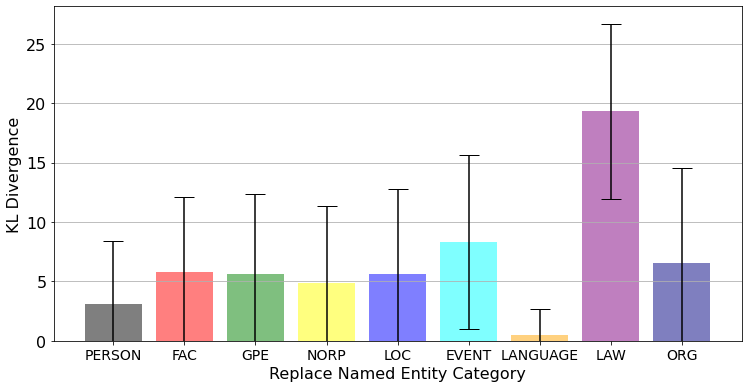

In [203]:
# Build the plot
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
ax.bar(x_pos, medians, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10,
      color=['black', 'red', 'green', 'yellow', 'blue', 'cyan', 'orange', 'purple', 'navy'])
ax.set_ylabel('KL Divergence', fontsize=16)
ax.set_xlabel('Replace Named Entity Category', fontsize=16)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_s, fontsize=14)
ax.yaxis.grid(True)
plt.ylim(bottom=0)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()